# Assignment 1 Pokemon Image Generation DCGAN


I trained a DCGAN model for generating Pokemon images (though it seems like it takes a lot of epochs to generate proper images)

Downloaded Dataset from Kaggle : https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

In [7]:
import tensorflow as tf
import tensorflow.keras.layers as layers # type: ignore

In [8]:
import os
import PIL
import imageio
from IPython import display

In [9]:
import time
import pathlib

In [10]:
print(tf.__version__)

2.12.0


In [11]:
dataset_path = "./pokemon_Dataset"
data_dir = pathlib.Path(dataset_path)

#### Preprocessing data and making a dataset

In [12]:
BATCHSIZE = 64
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

list_ds = tf.data.Dataset.list_files(str(data_dir/'*'))

def preprocess(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img,channels=3)
    img.set_shape([None,None,3])
    
    #reshaping to 64x64 size
    
    img = tf.image.resize(images=img,size=[IMAGE_HEIGHT,IMAGE_WIDTH])
    img = (img - 127.5)/127.5
    return img

image_ds = list_ds.map(map_func=preprocess,num_parallel_calls=tf.data.AUTOTUNE)
image_ds = image_ds.take(-1)


In [13]:
image_ds = image_ds.cache().shuffle(1000).batch(BATCHSIZE).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(image_ds).shuffle(1000).batch(BATCHSIZE)

Set the size of input noise (Latent size) to the generator as 128(First tried it with 100,images are not good, so increased it)

In [15]:
LATENTSIZE = 128

# Generator Model 

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()

    dim = IMAGE_WIDTH // 4

    model.add(tf.keras.layers.Dense(dim*dim*256, use_bias=False, input_shape=(LATENTSIZE,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((dim, dim, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    print(model.output_shape)
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    print(model.output_shape)
    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    print(model.output_shape)
    return model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(None, 16, 16, 128)
(None, 32, 32, 64)
(None, 64, 64, 3)
(1, 64, 64, 3)


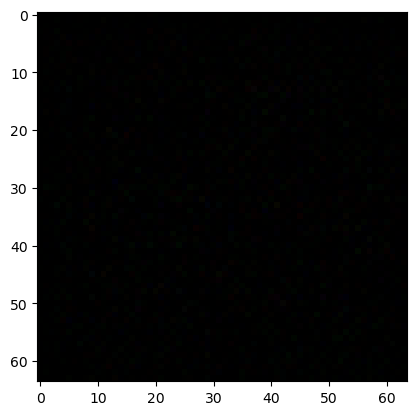

In [17]:
generator = make_generator_model()

noise = tf.random.normal([1,LATENTSIZE])
generated_image = generator(noise,training = False)

plt.imshow(generated_image[0,:,:,:])
print(generated_image.shape)

# Discriminator model

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

discriminator = make_discriminator_model()


#### Defining Optimizers,losses

In [19]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [21]:
def discriminator_loss(real_outputs,fake_outputs):
    real_loss = cross_entropy(tf.ones_like(real_outputs),real_outputs)
    fake_loss = cross_entropy(tf.zeros_like(fake_outputs),fake_outputs)
    total_loss = real_loss + fake_loss
    return total_loss

In [22]:
def generator_loss(fake_outputs):
    return cross_entropy(tf.ones_like(fake_outputs),fake_outputs)

In [23]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,discriminator_optimizer = discriminator_optimizer
                                ,generator = generator,discriminator = discriminator)

In [24]:
#number of epochs for training

EPOCHS = 500

#number of examples to generate

NUMBER_OF_EXAMPLES = 16

seed = tf.random.normal([NUMBER_OF_EXAMPLES,LATENTSIZE])

In [25]:
@tf.function
def train_step(images):
    tf.random.set_seed(42)
    noise = tf.random.normal([BATCHSIZE,LATENTSIZE])
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training = True)
        
        
        real_output = discriminator(images,training = True)
        fake_output = discriminator(generated_images,training = True)
        
        #calculate loss
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    #calculate gradient
    
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    #update parameters
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

    return gen_loss,disc_loss

In [27]:
def generate_and_save_images(model,epoch,test_input):
    
    predictions = model(test_input,training = False)
    
    fig = plt.figure(figsize = (4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        
        #code to plot a RBG image by matplotlib
        
        rbg_image = np.stack([predictions[i,:,:,0].numpy(),predictions[i,:,:,1].numpy(),predictions[i,:,:,2].numpy()],axis=-1)
        rbg_image = np.clip(rbg_image,0,1)
        plt.imshow(rbg_image)
        plt.axis('off')
        
    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.show()

# Training Loop

In [30]:
def train(dataset,epochs):
    
    #lists to store loss in each epoch
    
    disc_loss,gen_loss = [],[]
    
    for epoch in range(epochs):
        start = time.time()
        
        #calculate loss over entire dataset
        
        bglos,dglos = 0.0,0.0
        for image_batch in dataset:
            glos,dlos = train_step(image_batch)
            bglos += glos
            dglos += dlos

        disc_loss.append(dglos)
        gen_loss.append(bglos)

        display.clear_output(wait = True)
        generate_and_save_images(generator,epoch + 1,seed)
        
        #save model after every 15 epochs
        if (epoch + 1)%15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch + 1,time.time() - start))
        print('Discriminator loss : {} and Generator loss : {}'.format(dglos,bglos))
        
    display.clear_output(wait = True)
    generate_and_save_images(generator,epochs,seed)

    return disc_loss,gen_loss

#### Trained model for 500 epochs

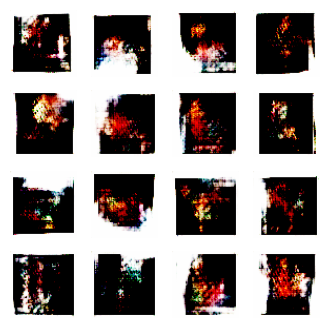

In [31]:
dis_loss,gen_loss = train(image_ds,EPOCHS)

In [58]:
miny_dislooss = min(dis_loss)
miny_genloss = min(gen_loss)
print(miny_dislooss,miny_genloss)

tf.Tensor(2.0352652, shape=(), dtype=float32) tf.Tensor(15.012439, shape=(), dtype=float32)


##### Minimum Discriminator loss = 2.0352 and Minimum Generator loss = 15.0124

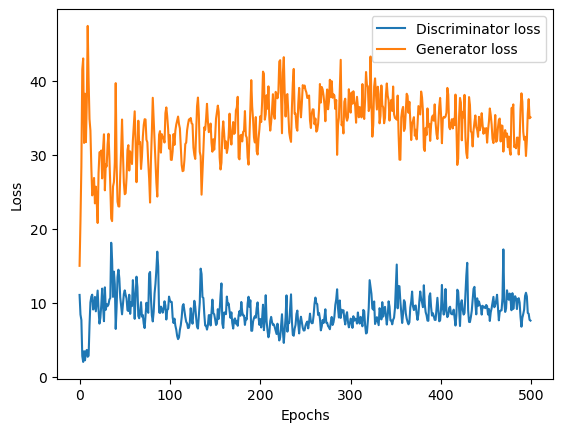

In [35]:
plt.plot(np.arange(500),dis_loss,label = "Discriminator loss")
plt.plot(np.arange(500),gen_loss,label = "Generator loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig("plot1.png")


In [36]:
LATENTSIZE = 128
EPOCHS = 500


# Updated generator model

Added a additional Conv2DTranspose layer to the model

In [37]:
def make_generator_model2():
    model = tf.keras.Sequential()

    dim = IMAGE_WIDTH // 4

    model.add(tf.keras.layers.Dense(dim*dim*256, use_bias=False, input_shape=(LATENTSIZE,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((dim, dim, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(32, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    print(model.output_shape)
    return model

# Updated Discriminator model

Added a additional Conv2D layer to the model

In [41]:
def make_discriminator_model2():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    print(model.output_shape)
    return model

In [42]:
generator2 = make_generator_model2()
discriminator2 = make_discriminator_model2()

(None, 64, 64, 3)
(None, 1)


In [43]:
checkpoint_dir = "./training_checkpoints2"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt2")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,discriminator_optimizer = discriminator_optimizer
                                ,generator = generator2,discriminator = discriminator2)

In [44]:
@tf.function
def train_step2(images):
    tf.random.set_seed(42)
    noise = tf.random.normal([BATCHSIZE,LATENTSIZE])
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator2(noise,training = True)
        
        real_output = discriminator2(images,training = True)
        fake_output = discriminator2(generated_images,training = True)
        
        #calculate lossses
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
      
    #calculate gradients
    
    gradients_of_generator = gen_tape.gradient(gen_loss,generator2.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator2.trainable_variables)
    
    #update parameters
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator2.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator2.trainable_variables))

    return gen_loss,disc_loss

In [45]:
def train2(dataset,epochs):
    #lists to store losses
    
    disc_loss,gen_loss = [],[]
    for epoch in range(epochs):
        start = time.time()
        
        bglos,dglos = 0.0,0.0
        for image_batch in dataset:
            glos,dlos = train_step2(image_batch)
            bglos += glos
            dglos += dlos

        disc_loss.append(dglos)
        gen_loss.append(bglos)

        display.clear_output(wait = True)
        generate_and_save_images(generator2,epoch + 1,seed)
        
        
        if (epoch + 1)%15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch + 1,time.time() - start))
        print('Discriminator loss : {} and Generator loss : {}'.format(dglos,bglos))
        
    display.clear_output(wait = True)
    generate_and_save_images(generator2,epochs,seed)

    return disc_loss,gen_loss

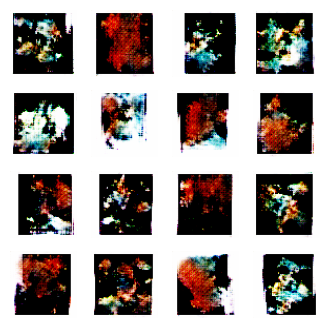

In [47]:
updated_discloss,updated_genloss = train2(image_ds,EPOCHS)

In [57]:
min_disloss = min(updated_discloss)
min_genloss = min(updated_genloss)
print(min_disloss,min_genloss)

tf.Tensor(0.26206335, shape=(), dtype=float32) tf.Tensor(27.87491, shape=(), dtype=float32)


#### Discriminator loss : 0.26206 and Generator loss : 27.8749

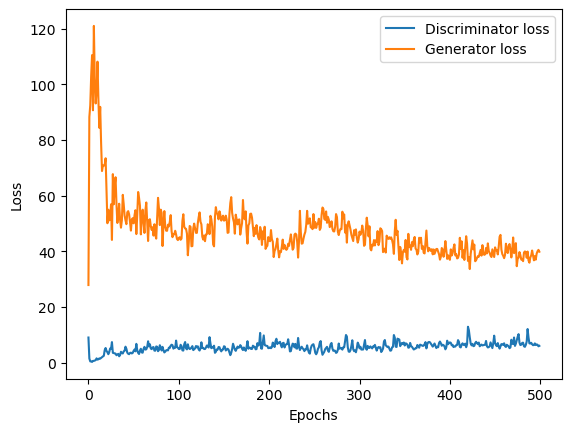

In [48]:
plt.plot(np.arange(500),updated_discloss,label = "Discriminator loss")
plt.plot(np.arange(500),updated_genloss,label = "Generator loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig("plot2.png")

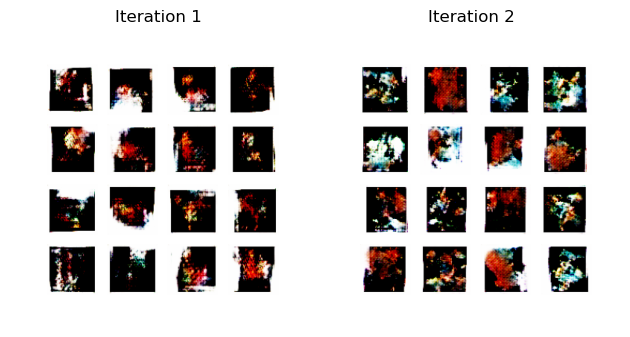

In [5]:
img2 = img.imread('image_at_epoch_500.png')
img1 = img.imread('images6/image_at_epoch_500.png')


fig, axs = plt.subplots(1, 2)

axs[0].imshow(img1)
axs[0].axis('off')
axs[0].set_title('Iteration 1')

axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title('Iteration 2')


plt.tight_layout()
plt.show()

# Conclusion

I did not get proper images as you can see above even after changing the model.This might be due to lesser number of images in the dataset(there are only 819 data points/pokemons in the dataset).

As you can see second plot loss is steadily decreasing and slowly decreasing while in the first plot there is no sign of loss decreasing in 500 epochs.

So by increasing the number of epochs to may be 2500 or 5000 we can actually get better images by second model

By using the second model, discriminator loss decreased by more than 5% and generator loss increased even after increasing layers compared to first model

Clearly images in Iteration 2 are better than Iteration 1 (observed in past 100 epochs).

One interesting observation I found while training the model in both iterations is that images are learning various colors while creating random noise in them for 20-30 epochs and slowly build upon each color.As you can see in the above image at around epoch 500 it's training majorly on red color.

I couldn't train the model for more epochs mainly due to time,it took 3hr to train each iteration for 500 epochs